### Notebook Summary
We will select features by using the addition of the L1 norm to the loss of the LSTM network, thus we will get the more important features by checking the absolute value of the weights.
Finally, I re-ran the network on the reduced features, the accuracy improved in the weekly and monthly forecast, but we will note that this network was not only designed to adjust the weights to the information because of the loss, therefore we will take the results with limited responsibility and later on in the project I will use the features I found here to run the forecasting algorithm

In [1]:
from google.colab import drive
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
Consecutive_stocks =  pd.read_csv('/content/drive/MyDrive/stocks_data/Consecutive_stocks.csv')
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.utils import resample
from collections import Counter

def preprocess_data(df, label_col='label_week', seq_length=10, start_date='2022-12-31', exclude_columns=[], alpha=0.8,device = 'cpu'):
  """
    Preprocesses time-series stocks data to sequences that will fid neural network lstm.

    Args:
        df (DataFrame): The input time-series data.
        label_col (str): The column in the DataFrame containing the target labels.
        seq_length (int): The length of sequences to create for training the model.
        start_date (str): The starting date for considering data in the preprocessing.
        exclude_columns (list): Columns to be excluded during preprocessing.
        alpha (float): A parameter used to split the data into training and testing sets.
        device (str): Specifies the device for PyTorch tensors (CPU or GPU).

    Returns:
        tuple: Four PyTorch tensors: sequences_train, labels_train, sequences_test, and labels_test.

    The preprocess_data function takes a DataFrame df containing time-series data, processes it,
    and prepares it for training and testing a machine learning model. It handles tasks such as handling
    missing values, scaling features, creating sequences, and addressing class imbalance.

    """
    df = df.copy().fillna(-1)
    all_columns = df.columns
    columns_to_keep = list(set(all_columns) - set(exclude_columns))

    df = df[pd.to_datetime(df['date']) >= pd.to_datetime(start_date)]
    min_date = pd.to_datetime(df['date']).min()
    max_date = pd.to_datetime(df['date']).max()
    num_days = (max_date - min_date).days
    split_date = min_date + pd.DateOffset(days=int(alpha * num_days))


    df.set_index(['date', 'Symbol'], inplace=True)
    label_col_copy = df[label_col].copy()

    scaler = StandardScaler()
    df[columns_to_keep] = scaler.fit_transform(df[columns_to_keep])
    df[label_col] = label_col_copy

    train_data = df[pd.to_datetime(df.index.get_level_values('date')) <= split_date].loc[:, columns_to_keep]
    test_data = df[pd.to_datetime(df.index.get_level_values('date')) > split_date].loc[:, columns_to_keep]

    sequences_train, labels_train = [], []
    for symbol in train_data.index.get_level_values('Symbol').unique():
        symbol_data = train_data.loc[train_data.index.get_level_values('Symbol') == symbol]
        symbol_sequences, symbol_labels = create_sequences(symbol_data[train_data.columns[:-1]], symbol_data[label_col], seq_length)
        sequences_train.append(symbol_sequences)
        labels_train.append(symbol_labels)

    sequences_test, labels_test = [], []
    for symbol in test_data.index.get_level_values('Symbol').unique():
        symbol_data = test_data.loc[test_data.index.get_level_values('Symbol') == symbol]
        symbol_sequences, symbol_labels = create_sequences(symbol_data[test_data.columns[:-1]], symbol_data[label_col], seq_length)
        sequences_test.append(symbol_sequences)
        labels_test.append(symbol_labels)

    sequences_test = torch.cat(sequences_test).to(device)
    labels_test = torch.cat(labels_test).to(device)
    sequences_train = torch.cat(sequences_train).to(device)
    labels_train = torch.cat(labels_train).to(device)
    #Handlling unbalanced data with taking randonly equaly nuber of samples from each class

    # Extract unique class labels
    unique_classes = set(labels_train.cpu().numpy())

    # Find the minimum count among classes
    min_samples = min(labels_train.tolist().count(c) for c in unique_classes)


    class_sequences = []
    class_labels = []
    for c in unique_classes:
        indices = [i for i, label in enumerate(labels_train) if torch.equal(label, torch.tensor(c))]
        random_indices = torch.randperm(len(indices))[:min_samples]

        class_sequences.extend([sequences_train[i] for i in random_indices])
        class_labels.extend([labels_train[i] for i in random_indices])

    # Combine the sequences and labels for each class
    sequences_train = torch.stack(class_sequences)
    labels_train = torch.stack(class_labels)

    return sequences_train, labels_train, sequences_test, labels_test


def create_sequences(data, labels, seq_length=7):
    sequences, next_labels = [], []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i + seq_length]
        label = labels.iloc[i + seq_length]
        if label == -1:
          continue
        sequences.append(seq.values)
        next_labels.append(label)

    sequences = np.array(sequences, dtype=np.float32)
    next_labels = np.array(next_labels, dtype=np.int64)

    return torch.tensor(sequences).to(device), torch.tensor(next_labels).to(device)

def visualize_feature_relevance(model, df, label_col):
  # Exclude some columns from the 'df' DataFrame
    columns_to_exclude = ['label_day', 'label_week', 'label_month', 'Symbol', 'date','pct_change_week','pct_change_month', 'stock']

    # Assuming feature_names is a list of feature names corresponding to the input_size
    all_columns = df.columns
    feature_names = list(set(all_columns) - set(columns_to_exclude))

    # Extract learned coefficients (weights) from the LSTM model
    weights = model.lstm.weight_ih_l0.detach().numpy()
    # Create a DataFrame to store feature names and weights
    feature_relevance_df = pd.DataFrame({'Feature': feature_names, 'Absolute_Weight': np.abs(weights[0, :])})

    # Plot the relevance of each feature
    plt.bar(range(len(weights[0, :])), feature_relevance_df['Absolute_Weight'])
    plt.xlabel('Feature')
    plt.ylabel('Absolute Weight')
    plt.title(f'Feature Relevance with L1 Regularization-{len(feature_names)} features for {label_col}')
    plt.show()
    feature_relevance_df.sort_values(by='Absolute_Weight', ascending=False,inplace = True)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    print(feature_relevance_df)

    return feature_relevance_df


def top_features(feature_relevance_df, top_X=20):

    top_feature_names = feature_relevance_df['Feature'].head(top_X).tolist()
    return top_feature_names


In [15]:
import torch.nn.functional as F

def lstm_pipline(df, label_col='label_week',columns_to_use=[], seq_length=10, hidden_size=64, num_layers=2, num_classes=8, lr=0.01, num_epochs=5, batch_size=128, alpha_lasso=0.01, alpha=0.8, start_date='2022-12-31',device = 'cpu'):
    # Preprocess data and get train and test data
    # Exclude some columns from the 'df' DataFrame
    if label_col == 'label_week':
        columns_to_exclude = ['label_day',  'label_month', 'Symbol', 'date','pct_change_week','pct_change_month', 'stock']
    elif label_col == 'label_day':
        columns_to_exclude = [ 'label_week', 'label_month', 'Symbol', 'date','pct_change_week','pct_change_month', 'stock']
    elif label_col == 'label_month':
        columns_to_exclude = ['label_day', 'label_week',  'Symbol', 'date','pct_change_week','pct_change_month', 'stock']

    if len(columns_to_use)>0:
      print('Testing feature selection results')
      all_columns = df.columns
      columns_to_exclude = list(set(all_columns) - set(columns_to_use+[label_col]))

    print(f'Preprocessing and creating sequences, label column is {label_col}...')
    sequences_train, labels_train, sequences_test, labels_test = preprocess_data(df, label_col=label_col, seq_length=seq_length, start_date=start_date, exclude_columns=columns_to_exclude, alpha=alpha)

    # Create DataLoader for training
    train_dataset = TensorDataset(sequences_train, labels_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Create DataLoader for testing
    test_dataset = TensorDataset(sequences_test, labels_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    class LSTM(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers, num_classes):
            super(LSTM, self).__init__()
            self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, num_classes)

        def forward(self, x):
            out, _ = self.lstm(x)
            out = self.fc(out[:, -1, :])
            return out

    # Automatically determine the input size from the data
    input_size = sequences_train.size(2)

    model = LSTM(input_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # L1 regularization
    l1_regularization = nn.L1Loss()
    print('Start training')

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader, 1):
            optimizer.zero_grad()
            outputs = model(inputs)

            # Calculate CrossEntropyLoss
            loss_ce = F.cross_entropy(outputs, labels)

            # L1 regularization
            reg_loss = torch.tensor(0., requires_grad=True).to(device)
            for param in model.parameters():
                norm = torch.norm(param.clone().detach(), p=1)
                reg_loss = reg_loss + norm  # Create a new tensor for accumulation


            # Total loss with L1 regularization
            loss = loss_ce + alpha_lasso * reg_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 1500 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i}/{len(train_loader)}], Loss: {running_loss / i:.4f}')

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    print('Evaluating')

    # In case i want to use this part to get predictions and there probabilities for the stocks
    model.eval()
    correct, total = 0, 0
    all_predictions, all_probabilities, all_real_labels = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probabilities = F.softmax(outputs, dim=1)
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
            all_real_labels.extend(labels.cpu().numpy())


    accuracy = correct / total #The accuracy wont be very good, the main perpose of this is to do feature selection
    print(f'Accuracy: {accuracy * 100:.2f}%')

    if len(columns_to_use)==0:
        print('Start features checking')
        feature_relevance_df = visualize_feature_relevance(model, df=Consecutive_stocks,label_col=label_col)

        return model, feature_relevance_df
    else:
        return model



In [16]:
train_test_ratio=0.8
top_X_features = 20
Nepochs = 3
start_date='2022-12-31'
hidden_size = 32
batch_size = 64

###Day

Preprocessing and creating sequences, label column is label_day...
Start training
Epoch [1/3], Loss: 34.3137
Epoch [2/3], Loss: 51.8026
Epoch [3/3], Loss: 64.3168
Evaluating
Accuracy: 36.17%
Start features checking


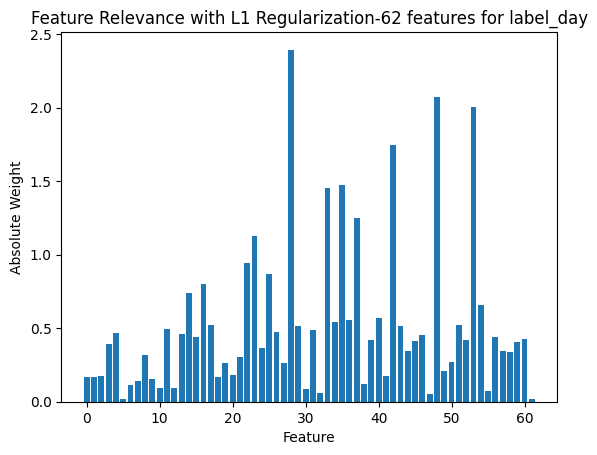

                                Feature  Absolute_Weight
28                                   ad         2.394953
48                            adx_short         2.074355
53                         adosc_medium         2.006029
42                            sma_short         1.747510
35                             atr_long         1.476215
33   ratio_pct_change_26_^GSPC_Industry         1.457320
37                             mom_long         1.251276
23  ratio_pct_change_100_^GSPC_Industry         1.124503
22                                  bop         0.947088
25                           adosc_long         0.868591
16                           apo_medium         0.800037
14                               Volume         0.738960
54              pct_change_100_Industry         0.658691
40                  pct_change_26_^GSPC         0.570660
36                            dema_long         0.557273
34                             mfi_long         0.539535
17                             

In [17]:
model_day, feature_relevance_df_day = lstm_pipline(df=Consecutive_stocks, label_col='label_day', seq_length=7, hidden_size=hidden_size, num_layers=2, num_classes=8, lr=0.01, num_epochs=Nepochs, batch_size=batch_size, alpha_lasso=0.01, alpha=train_test_ratio, start_date=start_date)


In [18]:
columns_to_use_day = top_features(feature_relevance_df_day, top_X=top_X_features)
model_day  = lstm_pipline(df=Consecutive_stocks, label_col='label_day',columns_to_use=columns_to_use_day ,seq_length=7, hidden_size=hidden_size, num_layers=2, num_classes=8, lr=0.01, num_epochs=Nepochs, batch_size=batch_size, alpha_lasso=0.01, alpha=train_test_ratio, start_date=start_date)


Testing feature selection results
Preprocessing and creating sequences, label column is label_day...
Start training
Epoch [1/3], Loss: 24.3495
Epoch [2/3], Loss: 35.3885
Epoch [3/3], Loss: 44.7532
Evaluating
Accuracy: 34.56%


###Week

Preprocessing and creating sequences, label column is label_week...
Start training
Epoch [1/3], Batch [1500/2738], Loss: 120.9017
Epoch [1/3], Loss: 152.4067
Epoch [2/3], Batch [1500/2738], Loss: 247.5327
Epoch [2/3], Loss: 269.3409
Epoch [3/3], Batch [1500/2738], Loss: 339.8390
Epoch [3/3], Loss: 356.9632
Evaluating
Accuracy: 41.53%
Start features checking


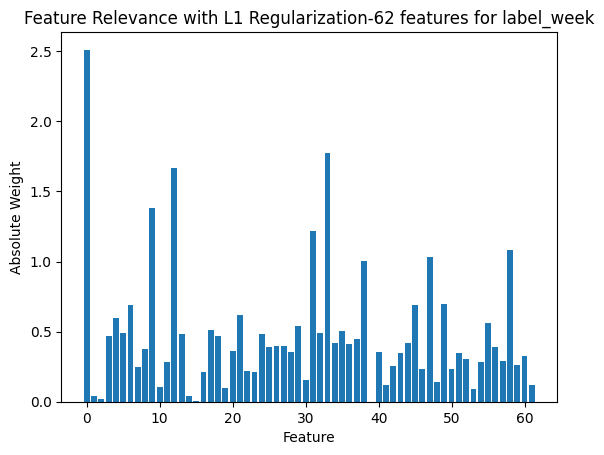

                                Feature  Absolute_Weight
0                  pct_change_100_^GSPC         2.510530
33   ratio_pct_change_26_^GSPC_Industry         1.774025
12                            cci_short         1.664230
9             ratio_pct_change_26_^GSPC         1.379164
31                           kama_short         1.217151
58                             adx_long         1.079178
47                            atr_short         1.034029
38                           mom_medium         1.004340
49                           mfi_medium         0.693902
45                             cci_long         0.692363
6            ratio_pct_change_100_^GSPC         0.690536
21                             rsi_long         0.619241
4                        pct_change_100         0.593731
55                          dema_medium         0.563671
29                            Adj Close         0.538664
17                                  sar         0.512507
35                             

In [19]:
model_week, feature_relevance_df_week = lstm_pipline(df=Consecutive_stocks, label_col='label_week', seq_length=10, hidden_size=hidden_size*2, num_layers=2, num_classes=8, lr=0.01, num_epochs=Nepochs, batch_size=batch_size*2, alpha_lasso=0.01, alpha=train_test_ratio, start_date=start_date)


In [20]:
columns_to_use_week = top_features(feature_relevance_df_week, top_X=top_X_features)
model_week = lstm_pipline(df=Consecutive_stocks, label_col='label_week',columns_to_use=columns_to_use_week, seq_length=10, hidden_size=hidden_size*2, num_layers=2, num_classes=8, lr=0.01, num_epochs=Nepochs, batch_size=batch_size*2, alpha_lasso=0.01, alpha=train_test_ratio, start_date=start_date)


Testing feature selection results
Preprocessing and creating sequences, label column is label_week...
Start training
Epoch [1/3], Batch [1500/2738], Loss: 97.7389
Epoch [1/3], Loss: 126.2162
Epoch [2/3], Batch [1500/2738], Loss: 213.0842
Epoch [2/3], Loss: 234.5514
Epoch [3/3], Batch [1500/2738], Loss: 303.6879
Epoch [3/3], Loss: 321.7175
Evaluating
Accuracy: 43.09%


###Month

Preprocessing and creating sequences, label column is label_month...
Start training
Epoch [1/3], Batch [1500/1888], Loss: 292.1357
Epoch [1/3], Loss: 326.7461
Epoch [2/3], Batch [1500/1888], Loss: 650.6404
Epoch [2/3], Loss: 688.1941
Epoch [3/3], Batch [1500/1888], Loss: 1008.5063
Epoch [3/3], Loss: 1040.8275
Evaluating
Accuracy: 61.89%
Start features checking


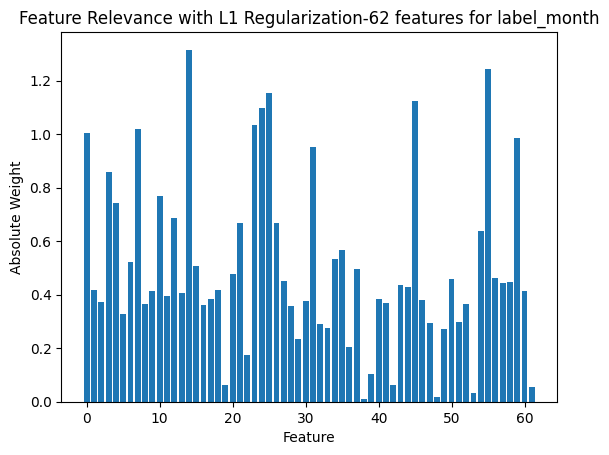

                                Feature  Absolute_Weight
14                               Volume         1.315420
55                          dema_medium         1.242223
25                           adosc_long         1.152488
45                             cci_long         1.124565
24                       Sector_encoded         1.097376
23  ratio_pct_change_100_^GSPC_Industry         1.032611
7                         pct_change_26         1.017359
0                  pct_change_100_^GSPC         1.003184
59                            apo_short         0.985293
31                           kama_short         0.951362
3                            rsi_medium         0.856919
10                     Industry_encoded         0.769463
4                        pct_change_100         0.743815
12                            cci_short         0.684964
26                            ema_short         0.667967
21                             rsi_long         0.666047
54              pct_change_100_

In [21]:
model_month, feature_relevance_df_month = lstm_pipline(df=Consecutive_stocks, label_col='label_month', seq_length=15, hidden_size=hidden_size*4, num_layers=2, num_classes=8, lr=0.01, num_epochs=Nepochs, batch_size=batch_size*4, alpha_lasso=0.01, alpha=train_test_ratio, start_date=start_date)


In [22]:
columns_to_use_month = top_features(feature_relevance_df_month, top_X=top_X_features)
model_month = lstm_pipline(df=Consecutive_stocks, label_col='label_month',columns_to_use=columns_to_use_month, seq_length=15, hidden_size=hidden_size*4, num_layers=2, num_classes=8, lr=0.01, num_epochs=Nepochs, batch_size=batch_size*4, alpha_lasso=0.01, alpha=train_test_ratio, start_date=start_date)


Testing feature selection results
Preprocessing and creating sequences, label column is label_month...
Start training
Epoch [1/3], Batch [1500/1888], Loss: 257.5539
Epoch [1/3], Loss: 288.4924
Epoch [2/3], Batch [1500/1888], Loss: 583.5913
Epoch [2/3], Loss: 621.4392
Epoch [3/3], Batch [1500/1888], Loss: 948.5559
Epoch [3/3], Loss: 982.4263
Evaluating
Accuracy: 64.05%


In [23]:
import pandas as pd
#Save selected features names

df = pd.DataFrame({
    'columns_to_use_day': columns_to_use_day,
    'columns_to_use_week': columns_to_use_week,
    'columns_to_use_month': columns_to_use_month
})

df.to_csv('/content/drive/MyDrive/stocks_data/selected_columns.csv', index=False)
